### Differential expression analysis

In [18]:
### Load required packages
library(clusterProfiler)
library(enrichplot)
library(dplyr)
library(ggplot2)
library(org.Mm.eg.db)
library(DESeq2)
library(ggpubr)

In [19]:
### Load count table
output = "./deseq2/"
count_df = read.table("./feature_count/gene_counts.txt", comment.char = "#", header = TRUE)
rownames(count_df) = count_df[, 1]
count_df = count_df[, -c(1:6)]
# ### get the sample name
colnames(count_df) = sapply(colnames(count_df), function(x){
    x = sub("_Aligned\\.sortedByCoord\\.out\\.bam", "", x)
    sub("\\.\\.star\\.\\.", "", x)
})
head(count_df)

,01V1,02V1,03V1,04V1,05V1,06V1,07V1,08V1,09V1,10V1,11V1,12V1,13V1,14V1,15V1,16V1,17V1,18V1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AL627309.1,7,10,9,13,17,11,4,12,9,0,3,3,2,3,2,2,1,3
AL627309.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AL627309.2,0,0,0,0,0,0,0,0,0,0,0,2,1,1,2,0,3,3


In [20]:
### assign sample information
sample_df = data.frame(samples = colnames(count_df), 
                       cellline = c(rep("C42", 9), rep("PC3", 9)), 
                       genotype = rep(rep(c("control", "ko1","ko2"), each = 3), 2))
rownames(sample_df) = colnames(count_df)
# colnames(sample_df) = c("Genotype", "Treatment", "Age")
sample_df$Group = paste0(sample_df$cellline, "@", sample_df$genotype)
sample_df

,samples,cellline,genotype,Group
,<chr>,<chr>,<chr>,<chr>
01V1,01V1,C42,control,C42@control
02V1,02V1,C42,control,C42@control
03V1,03V1,C42,control,C42@control
04V1,04V1,C42,ko1,C42@ko1
05V1,05V1,C42,ko1,C42@ko1
06V1,06V1,C42,ko1,C42@ko1
07V1,07V1,C42,ko2,C42@ko2
08V1,08V1,C42,ko2,C42@ko2
09V1,09V1,C42,ko2,C42@ko2


### Analysis on PC3

In [22]:
sample_df  = sample_df %>%
  filter(cellline == "PC3")
count_df = count_df[, sample_df$samples]
head(sample_df)
head(count_df)

,samples,cellline,genotype,Group
,<chr>,<chr>,<chr>,<chr>
10V1,10V1,PC3,control,PC3@control
11V1,11V1,PC3,control,PC3@control
12V1,12V1,PC3,control,PC3@control
13V1,13V1,PC3,ko1,PC3@ko1
14V1,14V1,PC3,ko1,PC3@ko1
15V1,15V1,PC3,ko1,PC3@ko1


,10V1,11V1,12V1,13V1,14V1,15V1,16V1,17V1,18V1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
MIR1302-2HG,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0
AL627309.1,0,3,3,2,3,2,2,1,3
AL627309.3,0,0,0,0,0,0,0,0,0
AL627309.2,0,0,2,1,1,2,0,3,3


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



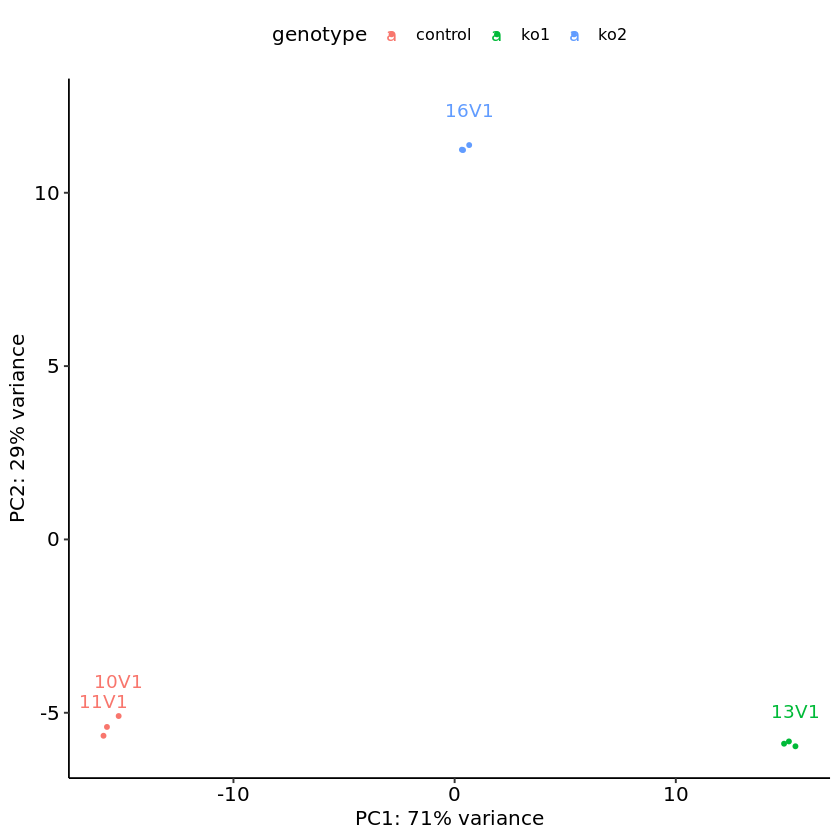

In [23]:
### First get PCA plot of the result
output = "./deseq2/PC3/"

sample_df$genotype = factor(sample_df$genotype, levels = c("control", "ko1", "ko2"))
dds <- DESeqDataSetFromMatrix(countData = count_df, colData = sample_df, design = ~genotype)
dds <- DESeq(dds)
pca_df = plotPCA(rlog(dds, blind = FALSE), intgroup = c("genotype"), returnData=TRUE)
percentVar <- round(100 * attr(pca_df, "percentVar"))

p = ggplot(pca_df, aes(PC1, PC2, color=genotype)) +
      geom_point(size=1) +
      xlab(paste0("PC1: ",percentVar[1],"% variance")) +
      ylab(paste0("PC2: ",percentVar[2],"% variance")) +
     geom_text(
        label=rownames(pca_df), 
        nudge_x =0, nudge_y =1, 
        check_overlap = T
      ) + theme_pubr()
print(p)
ggsave(paste0(output, "Scatter_pca.pdf"), p, width = 4.5, height = 5)

In [ ]:
### compare between different groups
source("./de_functions.r")

de_res_ko1 = pseudoBulkDE(count_df, 
                      sample_df, 
                      contrast = c('ko1', 'control'), 
                      output = output, 
                      group = "genotype", 
                      species = "human", 
                      design = ~genotype, 
                          pcut = 0.01)

de_res_ko2 = pseudoBulkDE(count_df, 
                      sample_df, 
                      contrast = c('ko2', 'control'), 
                      output = output, 
                      group = "genotype", 
                      species = "human", 
                      design = ~genotype, 
                          pcut = 0.01)

[1] "./deseq2/PC3//ko1_vs_control"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.56% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“There were 5 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(...):
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(...):
“For some

[1] "./deseq2/PC3//ko2_vs_control"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.04% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


### Result for C42

In [ ]:
sample_df  = sample_df %>%
  filter(cellline == "C42")
count_df = count_df[, sample_df$samples]
head(sample_df)
head(count_df)

In [ ]:
### First get PCA plot of the result
output = "./deseq2/C42/"

sample_df$genotype = factor(sample_df$genotype, levels = c("control", "ko1", "ko2"))
dds <- DESeqDataSetFromMatrix(countData = count_df, colData = sample_df, design = ~genotype)
dds <- DESeq(dds)
pca_df = plotPCA(rlog(dds, blind = FALSE), intgroup = c("genotype"), returnData=TRUE)
percentVar <- round(100 * attr(pca_df, "percentVar"))

p = ggplot(pca_df, aes(PC1, PC2, color=genotype)) +
      geom_point(size=1) +
      xlab(paste0("PC1: ",percentVar[1],"% variance")) +
      ylab(paste0("PC2: ",percentVar[2],"% variance")) +
     geom_text(
        label=rownames(pca_df), 
        nudge_x =0, nudge_y =1, 
        check_overlap = T
      ) + theme_pubr()
print(p)
ggsave(paste0(output, "Scatter_pca.pdf"), p, width = 4.5, height = 5)

In [ ]:
### compare between different groups
source("./de_functions.r")

de_res_ko1 = pseudoBulkDE(count_df, 
                      sample_df, 
                      contrast = c('ko1', 'control'), 
                      output = output, 
                      group = "genotype", 
                      species = "human", 
                      design = ~genotype, 
                          pcut = 0.01)

de_res_ko2 = pseudoBulkDE(count_df, 
                      sample_df, 
                      contrast = c('ko2', 'control'), 
                      output = output, 
                      group = "genotype", 
                      species = "human", 
                      design = ~genotype, 
                          pcut = 0.01)